In [1]:
#%% import
import os
from glob import glob
import re
import ast
import numpy as np 
import pandas as pd
from PIL import Image, ImageDraw 
from tqdm import tqdm
from dask import bag

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Dropout, Flatten
from keras.metrics import top_k_categorical_accuracy
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os

In [3]:
#%% set label dictionary and params
classfiles = os.listdir('../Data/')
numstonames = {i: v[:-4].replace(" ", "_") for i, v in enumerate(classfiles)} #adds underscores

num_classes = 340    #340 max 
imheight, imwidth = 32, 32  
ims_per_class = 500  #max?

In [4]:
# faster conversion function
def draw_it(strokes):
    image = Image.new("P", (256,256), color=255)
    image_draw = ImageDraw.Draw(image)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0])-1):
            image_draw.line([stroke[0][i], 
                             stroke[1][i],
                             stroke[0][i+1], 
                             stroke[1][i+1]],
                            fill=0, width=5)
    image = image.resize((imheight, imwidth))
    return np.array(image)/255.

#%% get train arrays
train_grand = []
class_paths = glob('../Data/*.csv')
for i,c in enumerate(tqdm(class_paths[0: num_classes])):
    train = pd.read_csv(c, usecols=['drawing'], nrows=ims_per_class*5//4)
    train = train.head(ims_per_class)
    imagebag = bag.from_sequence(train.drawing.values).map(draw_it) 
    trainarray = np.array(imagebag.compute())  # PARALLELIZE
    trainarray = np.reshape(trainarray, (ims_per_class, -1))    
    labelarray = np.full((train.shape[0], 1), i)
    trainarray = np.concatenate((labelarray, trainarray), axis=1)
    train_grand.append(trainarray)
    
train_grand = np.array([train_grand.pop() for i in np.arange(num_classes)]) #less memory than np.concatenate
train_grand = train_grand.reshape((-1, (imheight*imwidth+1)))

del trainarray
del train

0it [00:00, ?it/s]


IndexError: pop from empty list

In [ ]:
# memory-friendly alternative to train_test_split?
valfrac = 0.3
cutpt = int(valfrac * train_grand.shape[0])

np.random.shuffle(train_grand)
y_train, X_train = train_grand[cutpt: , 0], train_grand[cutpt: , 1:]
y_val, X_val = train_grand[0:cutpt, 0], train_grand[0:cutpt, 1:] #validation set is recognized==True

#del train_grand

y_train = keras.utils.to_categorical(y_train, num_classes)
X_train = X_train.reshape(X_train.shape[0], imheight, imwidth, 1)
y_valid = keras.utils.to_categorical(y_val, num_classes)
X_valid = X_val.reshape(X_val.shape[0], imheight, imwidth, 1)

y_val = y_valid[:len(y_valid)//2]
X_val = X_valid[:len(X_valid)//2]

y_test = y_valid[len(y_valid)//2:]
X_test = X_valid[len(X_valid)//2:]

print(y_train.shape, "\n",
      X_train.shape, "\n",
      y_val.shape, "\n",
      X_val.shape, "\n",
      y_test.shape, "\n",
      X_test.shape)

(119000, 340) 
 (119000, 32, 32, 1) 
 (25500, 340) 
 (25500, 32, 32, 1) 
 (25500, 340) 
 (25500, 32, 32, 1)


In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
])

inputs = keras.Input(shape=(32,32,1))
x = data_augmentation(inputs)
x = layers.Conv2D(filters=16, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=32, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Conv2D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2, strides=2)(x)
x = layers.Dropout(0.1)(x)

x = layers.Flatten()(x)

x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.2)(x)

outputs = layers.Dense(340, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 sequential_1 (Sequential)   (None, 32, 32, 1)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        160       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                       

In [ ]:
callbacks = [keras.callbacks.ModelCheckpoint(
    filepath="models/1_CNN_Model.h5", save_best_only=True, monitor="val_loss")]

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

history = model.fit(x=X_train, y=y_train,
          batch_size = 128,
          epochs = 100,
          validation_data = (X_val, y_val),
          callbacks = callbacks)

Epoch 1/100
930/930 [==============================] - 22s 17ms/step - loss: 5.7833 - accuracy: 0.0049 - val_loss: 6.0147 - val_accuracy: 0.0055
Epoch 2/100
930/930 [==============================] - 15s 16ms/step - loss: 5.4752 - accuracy: 0.0135 - val_loss: 5.9746 - val_accuracy: 0.0109
Epoch 3/100
930/930 [==============================] - 12s 13ms/step - loss: 5.2186 - accuracy: 0.0253 - val_loss: 5.7072 - val_accuracy: 0.0191
Epoch 4/100
930/930 [==============================] - 12s 13ms/step - loss: 5.0424 - accuracy: 0.0361 - val_loss: 5.4654 - val_accuracy: 0.0263
Epoch 5/100
930/930 [==============================] - 11s 12ms/step - loss: 4.9252 - accuracy: 0.0455 - val_loss: 5.4995 - val_accuracy: 0.0262
Epoch 6/100
930/930 [==============================] - 12s 13ms/step - loss: 4.8243 - accuracy: 0.0555 - val_loss: 5.0130 - val_accuracy: 0.0462
Epoch 7/100
930/930 [==============================] - 12s 13ms/step - loss: 4.7413 - accuracy: 0.0619 - val_loss: 4.9334 - val_ac

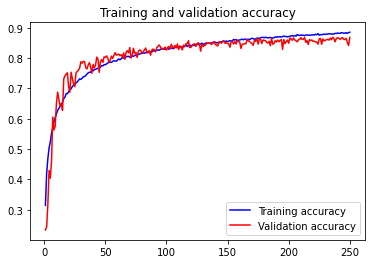

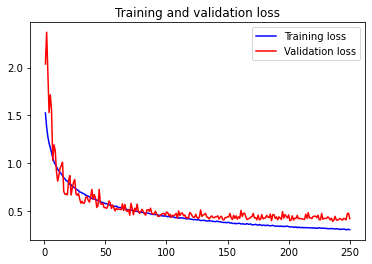

In [ ]:
def plot_function(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "b", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "r", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

plot_function(history)

In [ ]:
test_model = keras.models.load_model("models/1_CNN_Model.h5")
test_loss, test_acc = test_model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.3f}")

797/797 [==============================] - 3s 3ms/step - loss: 2.7451 - accuracy: 0.3637
Test accuracy: 0.364


In [ ]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
predictions = test_model.predict(X_test) 
y_pred = (predictions >= 0.5)
rounded_labels=np.argmax(y_test, axis=1)

matrix = metrics.confusion_matrix(rounded_labels, y_pred.argmax(axis=1))
matrix.diagonal()/matrix.sum(axis=1)
cmd = ConfusionMatrixDisplay(matrix, display_labels=['bee','butterfly','cat','dog','elephant'])
cmd.plot()

ValueError: The number of FixedLocator locations (340), usually from a call to set_ticks, does not match the number of ticklabels (5).

In [ ]:
label_frac_error = 1 - np.diag(matrix) / np.sum(matrix, axis=1)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')